In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
import operator
from sklearn.preprocessing import StandardScaler, Imputer
from scipy.spatial.distance import euclidean, cosine
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor


In [526]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [520]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [68]:
def rmse(yhat, y, round_to = None):
    ''' Return root mean squared error of a set of predictions '''
    err = np.sqrt(((yhat - y)**2).mean())
    if round_to:
        return round(err, round_to)
    else:
        return err

In [511]:
df = pd.read_csv('../data/data_for_model.csv', index_col='Season_Player')
df.drop([
    'Player', 'Season_Player.1', 'Season', 'Season_index'
], axis=1, inplace=True)

In [512]:
df['forward'] = (df['position'] != 'Defense')

In [513]:
df['signing_status'] = df.signing_status.apply(lambda x: 1 if 'UFA' else 0)

In [514]:
#These columns were causing problems
df.drop(['mean SH%', 'IPP', 'mean Faceoffs pct'], axis =1, inplace = True)

In [515]:
ycols = ['cap_hit', 'length', 'total_value', 'cap_pct', 'signing_year_cap']
xcols = ['forward', 'signing_age', 'signing_status'] + list(df.columns)[10:]

In [516]:
X, y = df[xcols], df[ycols]

In [517]:
X.shape

(1170, 197)

In [505]:
xcols[83], xcols[177], xcols[196]

('mean SH%', 'IPP', 'mean Faceoffs pct')

In [518]:
X.replace('-', 0, inplace=True)

X = X.apply(pd.to_numeric)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose = 1)
X = imp.fit_transform(X)

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [519]:
X.shape

(1170, 197)

In [380]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

In [381]:
X_train.shape, yp_train.shape, yl_train.shape, scap_train.shape

((994, 197), (994,), (994,), (994,))

In [375]:
def predict_global_mean(yp_train, yp_test, yl_train, yl_test):
    pcmp = yp_train.mean()
    print('RMSE pick mean cap_pct: {}%'.format(rmse(pcmp, yp_test, 2)))
    pcml = yl_train.mean()
    print('RMSE pick mean length: {} years'.format(rmse(pcml, yl_test, 1)))
    return pcmp, pcml

In [382]:
predict_global_mean(yp_train, yp_test, yl_train, yl_test)

RMSE pick mean cap_pct: 2.46%
RMSE pick mean length: 1.7 years


(2.6319617706237417, 2.244466800804829)

In [397]:
reg_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, KNeighborsRegressor]

def run_regressor(m = GradientBoostingRegressor):
    if m == LinearRegression:
        print(m.__name__)
        run_lin_regressor()
    else:
        print(m.__name__)
        model = m()
        model.fit(X_train, yp_train)
        cap_preds = model.predict(X_test)
        print('RMSE Cap_pct: {}%'.format(rmse(cap_preds, yp_test, 2)))

        Xl_train, Xl_test = X_train.copy(), X_test.copy()
        Xl_train = np.hstack((Xl_train, model.predict(Xl_train).reshape(-1,1)))
        Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1)))

        l_model = m()
        l_model.fit(Xl_train, yl_train)
        length_preds = l_model.predict(Xl_test)
        print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))
    
def run_lin_regressor():
    model = LinearRegression()
    model.fit(X_train, yp_train)
    cap_preds = model.predict(X_test)
    print('RMSE Cap_pct: {}%'.format(rmse(cap_preds, yp_test, 2)))

    Xl_train, Xl_test = X_train.copy(), X_test.copy()
    Xl_train = np.hstack((Xl_train, model.predict(Xl_train).reshape(-1,1), (Xl_train[:,1]**2).reshape(-1,1)))
    Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1), (Xl_test[:,1]**2).reshape(-1,1)))

    l_model = LinearRegression()
    l_model.fit(Xl_train, yl_train)
    length_preds = l_model.predict(Xl_test)
    print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))

In [400]:
for r in reg_list:
    run_regressor(r)
    print()

LinearRegression
RMSE Cap_pct: 1.21%
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 1.12%
RMSE Length: 1.2 years

GradientBoostingRegressor
RMSE Cap_pct: 0.98%
RMSE Length: 1.2 years

AdaBoostRegressor
RMSE Cap_pct: 1.36%
RMSE Length: 1.3 years

KNeighborsRegressor
RMSE Cap_pct: 1.35%
RMSE Length: 1.4 years



In [521]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

for r in reg_list:
    run_regressor(r)
    print()

RMSE pick mean cap_pct: 2.48%
RMSE pick mean length: 1.7 years

LinearRegression
RMSE Cap_pct: 0.96%
RMSE Length: 1.2 years

RandomForestRegressor
RMSE Cap_pct: 0.85%
RMSE Length: 1.1 years

GradientBoostingRegressor
RMSE Cap_pct: 0.86%
RMSE Length: 1.1 years

AdaBoostRegressor
RMSE Cap_pct: 1.13%
RMSE Length: 1.2 years

KNeighborsRegressor
RMSE Cap_pct: 1.15%
RMSE Length: 1.2 years



In [522]:
X2.shape

(994, 198)

In [418]:
reduced.shape

(994, 3)

In [421]:
len(xcols)

200

In [542]:
X2 = ss.fit_transform(X_train)

pca = PCA(n_components = 5).fit(X2)
reduced = np.dot(X2, pca.components_.T)

km = KMeans(n_clusters = 2)
clus = km.fit_transform(reduced)
X2 = np.hstack((X2, km.labels_.reshape(-1,1)))
#forwards['cluster'] = fkm.labels_

clusts = []
cmeans = []
for i in range(km.n_clusters):
    clusts.append(X2[km.labels_ == i])
    cmeans.append(clusts[i].mean(axis=0))


X2df = pd.DataFrame(X2, columns = xcols + ['cluster'])

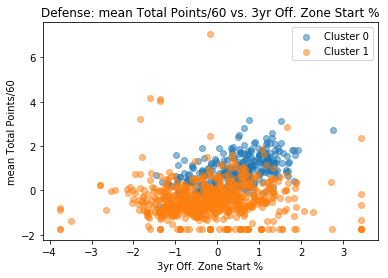

In [547]:
xax = '3yr Off. Zone Start %'
yax = 'mean Total Points/60'
a = 0.5

for i in range(km.n_clusters):
    plt.scatter(X2df[X2df.cluster == i][xax],
              X2df[X2df.cluster == i][yax], 
              label = 'Cluster {}'.format(i), alpha = a)


plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Defense: ' + yax + ' vs. ' + xax)

plt.show()

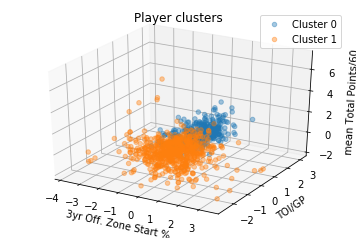

In [544]:
xax = '3yr Off. Zone Start %'
yax = 'TOI/GP'
zax = 'mean Total Points/60'
a=0.4

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for i in range(km.n_clusters):
    ax.scatter(X2df[X2df.cluster == i][xax],
              X2df[X2df.cluster == i][yax], 
              zs = X2df[X2df.cluster == i][zax], 
              label = 'Cluster {}'.format(i), alpha = a)

ax.set_xlabel(xax)
ax.set_ylabel(yax)
ax.set_zlabel(zax)
ax.set_title('Player clusters')

plt.legend()
plt.show()